<a href="https://colab.research.google.com/github/proveindia/MLAI/blob/main/discussion_19_1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Discussion 19:1: Building a Recommender System with SURPRISE

This discussion focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to [grouplens](https://grouplens.org/datasets/movielens/) and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.

**Note that the solution code provided below is just an example solution. You are encouraged to manipulate choose a different dataset than the one shown below and provide questions to generate different results based on your interest.**

**For this solution file the small grouplens dataset was used: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users**



In [ ]:
!pip install scikit-surprise

### Setting up data and algorithm paramters

In [ ]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, RandomizedSearchCV
import time
from scipy.stats import randint, uniform
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

# Define the file path for the uploaded ratings dataset
file_path = 'data/ratings_2019.csv'

# Load the dataset using pandas to check the structure
ratings = pd.read_csv(file_path)
print(ratings.head())
print ( ratings.columns)

#reduce dataset size
ratings=ratings.sample(10000)

# Define the reader format for the dataset
reader = Reader(line_format='user item rating timestamp', sep=',')

# Load the dataset from the file
data = Dataset.load_from_df(ratings[['userid', 'movie_id', 'rating']], reader)

                             userid  movie_id  rating                tstamp
0  8e7cebf9a234c064b75016249f2ac65e         1     5.0  2001-09-10 17:19:56 
1  8e7cebf9a234c064b75016249f2ac65e         2     4.0  2001-09-28 11:34:55 
2  8e7cebf9a234c064b75016249f2ac65e         3     4.0  2001-09-28 11:42:50 
3  8e7cebf9a234c064b75016249f2ac65e         5     5.0  2001-09-28 11:27:30 
4  8e7cebf9a234c064b75016249f2ac65e         6     4.0  2002-01-07 18:12:02 
Index(['userid', 'movie_id', 'rating', 'tstamp'], dtype='object')


In [ ]:
param_dists = {
    'KNNBasic': {
        'k': randint(10, 50),
        'min_k': randint(1, 5),
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson'],
            'user_based': [False, True]
        }
    },
    'SVD': {
        'n_factors': randint(50, 200),
        'n_epochs': randint(20, 50),
        'lr_all': uniform(0.002, 0.015),
        'reg_all': uniform(0.02, 0.1)
    },
    'NMF': {
        'n_factors': randint(15, 40),
        'n_epochs': randint(20, 50),
        'biased': [False, True]
    },
    'CoClustering': {
        'n_cltr_u': randint(3, 10),
        'n_cltr_i': randint(3, 10),
        'n_epochs': randint(20, 40)
    }
}

### Training pipeline

In [ ]:
algo_classes = {
    'KNNBasic': KNNBasic,
    'SVD': SVD,
    'NMF': NMF,
    'CoClustering': CoClustering
}

# Perform randomized search for each algorithm and measure training time
best_algorithms = {}
training_times = {}
testing_times = {}
for algo_name, param_dist in param_dists.items():
    print(f"Performing randomized search for {algo_name}...")
    start_time = time.time()
    rs = RandomizedSearchCV(algo_classes[algo_name], param_dist, measures=['mse'], cv=5, n_iter=20, random_state=42, n_jobs=-1)
    rs.fit(data)
    end_time = time.time()
    best_algorithms[algo_name] = rs.best_estimator['mse']
    training_times[algo_name] = end_time - start_time
    testing_times[algo_name] = 0  # Initialize test time
    print(f"Best parameters for {algo_name}: {rs.best_params['mse']}")
    print(f"Training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print("\n")

# Add SlopeOne to the best algorithms as it has no parameters to tune
best_algorithms['SlopeOne'] = SlopeOne()
training_times['SlopeOne'] = 0  # We won't measure the training time for SlopeOne as it has no parameters
testing_times['SlopeOne'] = 0  # Initialize test time for SlopeOne

# Perform cross-validation for the best algorithms found and measure training and testing times
results = {}
for algo_name, best_algo in best_algorithms.items():
    print(f"Evaluating {algo_name} with best parameters...")
    start_train_time = time.time()
    cv_results = cross_validate(best_algo, data, measures=['MSE'], cv=5, verbose=True, n_jobs=-1)
    end_train_time = time.time()

    # Sum up training and testing times
    training_times[algo_name] += (end_train_time - start_train_time) - sum(cv_results['fit_time'])
    testing_times[algo_name] += sum(cv_results['test_time'])

    results[algo_name] = cv_results['test_mse']
    print(f"Total training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print(f"Total testing time for {algo_name}: {testing_times[algo_name]:.2f} seconds")

# Find the optimal algorithm
optimal_algo = min(results, key=lambda x: results[x].mean())
optimal_mse = results[optimal_algo].mean()

print("\nOptimal Algorithm: ", optimal_algo)
print("Optimal Mean Squared Error (MSE): ", optimal_mse)
print("Training time for the optimal algorithm: {:.2f} seconds".format(training_times[optimal_algo]))
print("Testing time for the optimal algorithm: {:.2f} seconds".format(testing_times[optimal_algo]))

Performing randomized search for KNNBasic...
Best parameters for KNNBasic: {'k': 47, 'min_k': 2, 'sim_options': {'name': 'cosine', 'user_based': True}}
Training time for KNNBasic: 15.25 seconds


Performing randomized search for SVD...
Best parameters for SVD: {'lr_all': 0.010886218532930637, 'n_epochs': 22, 'n_factors': 100, 'reg_all': 0.08803075385877798}
Training time for SVD: 2.01 seconds


Performing randomized search for NMF...
Best parameters for NMF: {'biased': True, 'n_epochs': 40, 'n_factors': 16}
Training time for NMF: 4.50 seconds


Performing randomized search for CoClustering...
Best parameters for CoClustering: {'n_cltr_i': 3, 'n_cltr_u': 3, 'n_epochs': 29}
Training time for CoClustering: 7.34 seconds


Evaluating KNNBasic with best parameters...
Evaluating MSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     1.0466  1.0394  1.0708  0.9514  1.0796  1.0376  0.0456  
Fit time          0.03   

      Algorithm  Mean MSE   Std MSE  Training Time (s)  Testing Time (s)
0      KNNBasic  1.037577  0.045570          17.907419          0.072975
1           SVD  0.882628  0.035730           1.821970          0.044008
2           NMF  0.979376  0.016637           3.569977          0.040060
3  CoClustering  1.224911  0.030279           5.665583          0.033127
4      SlopeOne  1.086013  0.023200           0.030550          0.051720


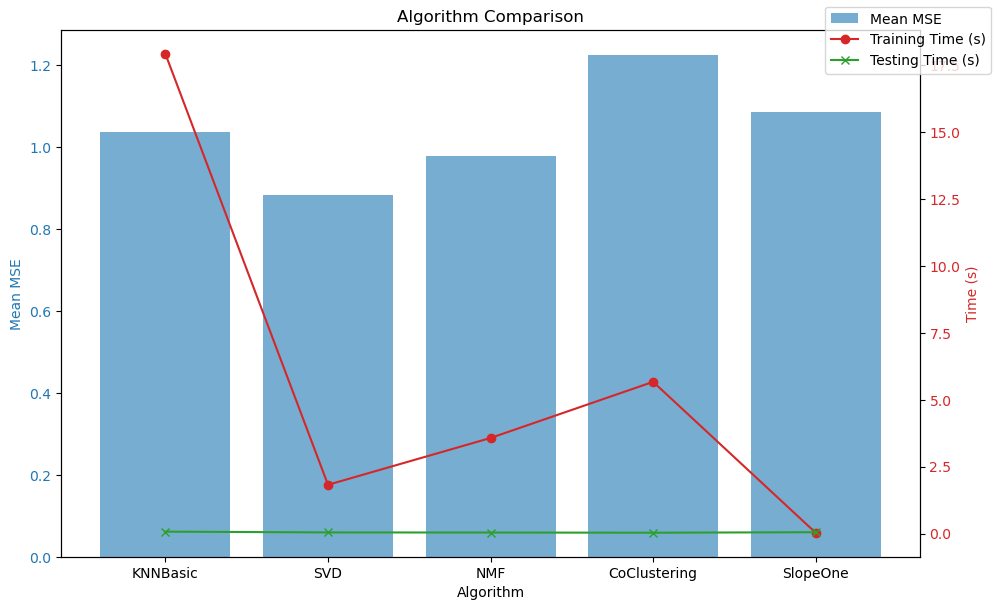

In [ ]:

# Create a DataFrame to display the results
df_results = pd.DataFrame({
    'Algorithm': list(results.keys()),
    'Mean MSE': [results[algo].mean() for algo in results],
    'Std MSE': [results[algo].std() for algo in results],
    'Training Time (s)': [training_times[algo] for algo in results],
    'Testing Time (s)': [testing_times[algo] for algo in results]
})

# Display the DataFrame
print(df_results)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Mean MSE', color=color)
ax1.bar(df_results['Algorithm'], df_results['Mean MSE'], color=color, alpha=0.6, label='Mean MSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results['Algorithm'], df_results['Training Time (s)'], color=color, marker='o', label='Training Time (s)')
ax2.plot(df_results['Algorithm'], df_results['Testing Time (s)'], color='tab:green', marker='x', label='Testing Time (s)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper right')
plt.title('Algorithm Comparison')
plt.show()